# Install packages, define functions

In [ ]:
#!pip install coba==4.8.6

In [ ]:
#!pip install vowpalwabbit==9.1.0

In [ ]:
#!pip install scipy==1.7.3

In [6]:
from coba.experiments import Experiment, Result
from coba.environments import Environments
from coba.learners import VowpalArgsLearner
from coba.pipes.filters import Reservoir, Shuffle

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

from scipy.stats import bootstrap
from scipy.optimize import minimize_scalar

In [7]:
def f(m, *data):
   q, x = data
   return q * np.sum(np.square(np.clip(x - m, a_min=0, a_max=None))) + (1 - q) * np.sum(np.square(np.clip(x - m, a_min=None, a_max=0)))

In [8]:
def calc_evar_cis(rewards, q=0.2, bounds=(-1,1)):

  def calc_evar_ci(rew, q=q, bounds=bounds):
    data = (q, rew)
    return float(minimize_scalar(f, bounds=bounds, method='bounded', args=data).x)

  rew_seq = (rewards,)  # samples must be in a sequence
  res = bootstrap(rew_seq, calc_evar_ci, confidence_level=0.95, vectorized=False, n_resamples=1000, batch=1024, random_state=42)
  ci_l, ci_u = res.confidence_interval
  return ci_l, ci_u

In [9]:
def calc_mean_cis(rewards, bounds=(-1,1)):
  rew_seq = (rewards,)  # samples must be in a sequence
  res = bootstrap(rew_seq, np.mean, confidence_level=0.95, n_resamples=1000, batch=1024, random_state=42)
  ci_l, ci_u = res.confidence_interval
  return ci_l, ci_u

In [10]:
def calc_evar(rew, q=0.2, bounds=(-1,1)):
  data = (q, rew)
  return float(minimize_scalar(f, bounds=bounds, method='bounded', args=data).x)

In [11]:
def calc_rate_cis(rewards):

  def calc_rate_ci(rew):
    return float(np.sum(rew)/len(rew))*100

  rew_seq = (rewards,)  # samples must be in a sequence
  res = bootstrap(rew_seq, calc_rate_ci, vectorized=False, confidence_level=0.95, n_resamples=1000, batch=1024, random_state=42)
  ci_l, ci_u = res.confidence_interval
  return ci_l, ci_u

In [12]:
# Creating a VW Learner with storing extra information about the selected action of each interaction, using this info for calculating 'No Sale (%)' results later

from coba.environments import Context, Action
from coba.learners.primitives import Info
from coba.contexts.core import InteractionContext
from coba.learners import VowpalArgsLearner

class VowpalArgsLearner_ActionLog(VowpalArgsLearner):

    def learn(self, context: Context, action: Action, reward: float, probability: float, info: Info) -> None:
        super().learn(context,action,reward,probability,info)
        InteractionContext.learner_info.update({"Selected_action": str(action)})

# Prudential insurance dataset simulation

In [13]:
import itertools
from typing import Optional, Hashable, Any, Union, Iterable, Dict
import csv

from coba.environments import SimulatedInteraction

Action      = Union[Hashable, dict]
Context     = Optional[Union[Hashable, dict]]
Feedback    = Any

class InsuranceOptimizationSimulation:
    """Simulation created from the prudential insurance csv file with features (context) and label (action).
    """

    def __init__(self, filename: str) -> None:
        self._filename = filename

    @property
    def params(self) -> Dict[str, Any]:
        """Paramaters describing the simulation."""
        return { "file": self._filename}

    def read(self) -> Iterable[SimulatedInteraction]:
        """Read the interactions in this simulation."""
        with open(self._filename, encoding='utf-8') as csvfile:
            
            rows           = csv.reader(csvfile, delimiter=',')
            rows_header    = next(rows, None)
            rows_iter      = itertools.islice(rows, 0, None)

            headers_dict = {k: v for v, k in enumerate(rows_header)}

            categorical_featurenames = ["Product_Info_1", "Product_Info_2", "Product_Info_3", "Product_Info_5", "Product_Info_6", "Product_Info_7", "Employment_Info_2", "Employment_Info_3", "Employment_Info_5", "InsuredInfo_1", "InsuredInfo_2", "InsuredInfo_3", "InsuredInfo_4", "InsuredInfo_5", "InsuredInfo_6", "InsuredInfo_7", "Insurance_History_1", "Insurance_History_2", "Insurance_History_3", "Insurance_History_4", "Insurance_History_7", "Insurance_History_8", "Insurance_History_9", "Family_Hist_1", "Medical_History_2", "Medical_History_3", "Medical_History_4", "Medical_History_5", "Medical_History_6", "Medical_History_7", "Medical_History_8", "Medical_History_9", "Medical_History_11", "Medical_History_12", "Medical_History_13", "Medical_History_14", "Medical_History_16", "Medical_History_17", "Medical_History_18", "Medical_History_19", "Medical_History_20", "Medical_History_21", "Medical_History_22", "Medical_History_23", "Medical_History_25", "Medical_History_26", "Medical_History_27", "Medical_History_28", "Medical_History_29", "Medical_History_30", "Medical_History_31", "Medical_History_33", "Medical_History_34", "Medical_History_35", "Medical_History_36", "Medical_History_37", "Medical_History_38", "Medical_History_39", "Medical_History_40", "Medical_History_41","Medical_Keyword_1","Medical_Keyword_2","Medical_Keyword_3","Medical_Keyword_4","Medical_Keyword_5","Medical_Keyword_6","Medical_Keyword_7","Medical_Keyword_8","Medical_Keyword_9","Medical_Keyword_10","Medical_Keyword_11","Medical_Keyword_12","Medical_Keyword_13","Medical_Keyword_14","Medical_Keyword_15","Medical_Keyword_16","Medical_Keyword_17","Medical_Keyword_18","Medical_Keyword_19","Medical_Keyword_20","Medical_Keyword_21","Medical_Keyword_22","Medical_Keyword_23","Medical_Keyword_24","Medical_Keyword_25","Medical_Keyword_26","Medical_Keyword_27","Medical_Keyword_28","Medical_Keyword_29","Medical_Keyword_30","Medical_Keyword_31","Medical_Keyword_32","Medical_Keyword_33","Medical_Keyword_34","Medical_Keyword_35","Medical_Keyword_36","Medical_Keyword_37","Medical_Keyword_38","Medical_Keyword_39","Medical_Keyword_40","Medical_Keyword_41","Medical_Keyword_42","Medical_Keyword_43","Medical_Keyword_44","Medical_Keyword_45","Medical_Keyword_46","Medical_Keyword_47","Medical_Keyword_48"]
            num_featurenames = ["Product_Info_4", "Ins_Age", "Ht", "Wt", "BMI", "Employment_Info_1", "Employment_Info_4", "Employment_Info_6", "Insurance_History_5", "Family_Hist_2", "Family_Hist_3", "Family_Hist_4", "Family_Hist_5"]
            disc_featurenames = ["Medical_History_1", "Medical_History_10", "Medical_History_15", "Medical_History_24", "Medical_History_32"]

            categorical_indices = [headers_dict[name] for name in categorical_featurenames]
            numeric_indices = [headers_dict[name] for name in num_featurenames]
            discrete_indices = [headers_dict[name] for name in disc_featurenames]

            target_index = headers_dict["Response"]

            actions = list(range(1,9))

            feedback = lambda actual: [(1-0.1*(actual-action)) if action<=actual else 0 for action in actions]

            for row in rows_iter:
                context = {}
                for i in categorical_indices:
                    context['cat_'+ str(i)] = 'c' + row[i]
                
                for i in numeric_indices:
                    if row[i] != '':
                        context['num_'+ str(i)] = float(row[i])
                        context['num_'+ str(i) + '_NA'] = 0
                    else:
                        context['num_'+ str(i) + '_NA'] = 1

                for i in discrete_indices:
                    if row[i] != '':
                        context['disc_'+ str(i)] = int(row[i])
                        context['disc_'+ str(i) + '_NA'] = 0
                    else:
                        context['disc_'+ str(i) + '_NA'] = 1

                rewards  = feedback(int(row[target_index]))
               
                yield SimulatedInteraction(context=context, actions=actions, rewards=rewards)

    def __repr__(self) -> str:
        return f'{{InsuranceOptimizationSimulation: {self._filename}}}'

In [14]:
dataset_path = 'insurance.csv' # Dataset path
num_instances = 59381
seed1 = 111
seed2 = 777
environment = Environments([InsuranceOptimizationSimulation(dataset_path)]).reservoir(num_instances,[seed2]).shuffle([seed1])

In [15]:
# Getting the true target for each interaction after shuffling to calculate 'No Sale (%)' results later
# For the learners it is done inside coba
dataset = pd.read_csv(dataset_path, sep=',', encoding='utf-8')

shuffled_dataset=list(Shuffle(seed1).filter(Reservoir(num_instances,seed2).filter(dataset['Response'])))

# Run learners, calculate performance metrics

## Risk-averse learner - Expectile loss with q=0.2

In [16]:
learner_q20 = [VowpalArgsLearner_ActionLog('--cb_explore_adf --squarecb --gamma_scale 654.8369214851169 --gamma_exponent 0.9808989298773739 --loss_function expectile --quantile_tau 0.2 --interactions xa --coin')]
result_q20 = Experiment(environment, learner_q20).evaluate()

2022-05-24 21:02:19 -- Processing chunk...
2022-05-24 21:02:19 --   * Recording Learner 0 parameters... (0.01 seconds) (completed)
2022-05-24 21:02:25 --   * Loading {InsuranceOptimizationSimulation: insurance.csv}... (5.53 seconds) (completed)
2022-05-24 21:02:25 --   * Creating Environment 0 from Loaded Source... (0.24 seconds) (completed)
2022-05-24 21:02:25 --   * Recording Environment 0 statistics... (0.0 seconds) (completed)
2022-05-24 21:03:30 --   * Evaluating Learner 0 on Environment 0... (65.14 seconds) (completed)


In [17]:
df_20=result_q20.interactions.to_pandas()

### EVaR q=0.2

In [18]:
calc_evar_cis(df_20.reward, q=0.2, bounds=(0,1))

(0.4140332738687006, 0.4165646426308426)

### Average

In [19]:
calc_mean_cis(df_20.reward)

(0.5339109475376247, 0.5378068996495275)

### No sale (%)

In [20]:
df_20_actions = list(map(lambda x: int(x), df_20['Selected_action']))

In [21]:
calc_rate_cis(np.array(shuffled_dataset)<np.array(df_20_actions))

(0.047153129788989744, 0.08757009817955237)

## Risk-neutral learner - Expectile loss with q=0.5

In [22]:
# Best learner from the hyperparameter search
learner_q50 = [VowpalArgsLearner_ActionLog('--cb_explore_adf --squarecb --gamma_scale 699.5817922481644 --gamma_exponent 0.9556705413691085 --loss_function expectile --quantile_tau 0.5 --interactions xa --coin')]
result_q50 = Experiment(environment, learner_q50).evaluate()

2022-05-24 21:17:58 -- Processing chunk...
2022-05-24 21:17:58 --   * Recording Learner 0 parameters... (0.05 seconds) (completed)
2022-05-24 21:18:05 --   * Loading {InsuranceOptimizationSimulation: insurance.csv}... (6.94 seconds) (completed)
2022-05-24 21:18:05 --   * Creating Environment 0 from Loaded Source... (0.34 seconds) (completed)
2022-05-24 21:18:05 --   * Recording Environment 0 statistics... (0.0 seconds) (completed)
2022-05-24 21:19:04 --   * Evaluating Learner 0 on Environment 0... (58.58 seconds) (completed)


In [23]:
df_50=result_q50.interactions.to_pandas()

### EVaR q=0.2

In [24]:
calc_evar_cis(df_50.reward, q=0.2, bounds=(0,1))

(0.38734547004479924, 0.3944480606480572)

### Average

In [25]:
calc_mean_cis(df_50.reward)

(0.6059826628276573, 0.6120916030141976)

### No Sale (%)

In [ ]:
df_50_actions = list(map(lambda x: int(x), df_50['Selected_action']))

In [27]:
calc_rate_cis(np.array(shuffled_dataset)<np.array(df_50_actions))

(16.415277456934707, 17.019859468624563)

## Summary

| $q$ | EVaR q=0.2 | Avg. (EVaR q=0.5) | No Sale (%)
| --- | --- | --- | --- |
| 0.2 | [0.414, 0.417] | [0.534, 0.538] | [0.0472, 0.0876]
| 0.5 | [0.387, 0.394] | [0.606, 0.612] | [16.4, 17.0]

# Plots

In [ ]:
evars_expectile_q20_l, evars_expectile_q20_m, evars_expectile_q20_h = [], [], []
evars_expectile_q50_l, evars_expectile_q50_m, evars_expectile_q50_h = [], [], []

for q in [0.1,0.2,0.3,0.4,0.5]:
  m = calc_evar(df_20.reward, q=q, bounds=(0,1)) 
  l, h = calc_evar_cis(df_20.reward, q=q, bounds=(0,1))
  #print('Expectile loss q=0.2: q=', q, l, m, h)
  evars_expectile_q20_l.append(l)
  evars_expectile_q20_m.append(m)
  evars_expectile_q20_h.append(h)

for q in [0.1,0.2,0.3,0.4,0.5]:
  m = calc_evar(df_50.reward, q=q, bounds=(0,1)) 
  l, h = calc_evar_cis(df_50.reward, q=q, bounds=(0,1))
  #print('Expectile loss q=0.5: q=', q, l, m, h)
  evars_expectile_q50_l.append(l)
  evars_expectile_q50_m.append(m)
  evars_expectile_q50_h.append(h)

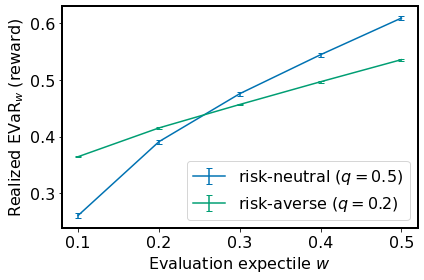

In [ ]:
plt.style.use('seaborn-colorblind')
plt.errorbar(np.linspace(0.1,0.5,5), evars_expectile_q50_m, [np.array(evars_expectile_q50_m)-np.array(evars_expectile_q50_l), np.array(evars_expectile_q50_h)-np.array(evars_expectile_q50_m)], capsize=3, label='risk-neutral ($q=0.5$)')
plt.errorbar(np.linspace(0.1,0.5,5), evars_expectile_q20_m, [np.array(evars_expectile_q20_m)-np.array(evars_expectile_q20_l), np.array(evars_expectile_q20_h)-np.array(evars_expectile_q20_m)], capsize=3, label='risk-averse ($q=0.2$)')

plt.xlabel('Evaluation expectile $w$', fontsize=16)
plt.ylabel('Realized EVaR$_w$ (reward)', fontsize=16)

plt.locator_params(axis='y', nbins=6)
plt.locator_params(axis='x', nbins=5)

plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.setp(plt.gca().spines.values(), linewidth=2)
plt.tight_layout()
plt.savefig('Prudential_dataset_3d982d2.pdf', bbox_inches='tight', facecolor='white')

## Hyperparameter search

In [ ]:
# Script used for hyperparameter search

from coba.environments import Environments
from coba.experiments import Experiment
from coba.learners import VowpalArgsLearner

import random

def hyperparams():
    gamma_scales, gamma_exponents = [], []
    for gamma_scale, gamma_exponent in (
    (
    1 + 999 * random.random(),
    0.01 + 0.99 * random.random()
    )
        for _ in range(59)
        ):
        gamma_scales.append(gamma_scale)
        gamma_exponents.append(gamma_exponent)
    
    return gamma_scales, gamma_exponents


gamma_scales, gamma_exponents = hyperparams()
learners = []
for scale, exponent in zip(gamma_scales, gamma_exponents):
    args = '--cb_explore_adf --squarecb --gamma_scale ' + str(scale) + ' --gamma_exponent ' + str(exponent) + ' --loss_function expectile --quantile_tau 0.2 --interactions xa --coin'
    #args = '--cb_explore_adf --squarecb --gamma_scale ' + str(scale) + ' --gamma_exponent ' + str(exponent) + ' --loss_function expectile --quantile_tau 0.5 --interactions xa --coin'
    learners.append(VowpalArgsLearner_ActionLog(args))

result_q20_hyper = Experiment(environment, learners).evaluate()
#result_q50_hyper = Experiment(environment, learners).evaluate()